# Analysis of experiments
In this notebook we present a simple routine to examine reactivities at varying concentration of SHAPE reagent.
In particular we focus on the different behaviour between nucleotides in GNRA tetraloops and the other nucleotides.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import RNA
import subprocess as sp
import regex
import seaborn as sns

##  Extraction and fitting of in-house experimental data.
The in-house data we used for the manuscript are available in the Github repository (file "SHAPE_data_cooperativity_series-2.xlsx").

We fit per-nucleotide reactivities as a function of reagent concentration, with the following power law:

$$R = \alpha\cdot C^\beta$$

We first linearize the power law

$$\log\frac{R}{C} = \log\alpha+(\beta-1)\log C$$

and then retrieve fit parameters $\alpha$ and $\beta$.

In [75]:
def intersect(x,y):
    out = []
    for i in range(len(x)):
        for j in range(len(y)):
            if x[i]==y[j]:
                out.append(x[i])
    return out

def fun(x,a,b):
    return a*x+b

import regex
from scipy.optimize import curve_fit
from scipy.stats import dirichlet

slope = []
slope_err = []

inter = []
inter_err = []

slope1 = []
slope1_err = []

inter1 = []
inter1_err = []

all_loop = []
all_stem = []

slope_g1 = []
inter_g1 = []

for name in ['2N2O', '2GIS', '2L1V', '1SCL', '1KXK', '1CQ5', '2GV4']:
    ## Read data-sheet and build sequence
    df = pd.read_excel('../experiments/SHAPE_data_cooperativity_series-2.xlsx', sheet_name=name, engine='openpyxl', skiprows=1)
    print(name)
    i0 = 0
    for s in df.seqRNA.values:
        if s not in ['A','U','C','G']:
            i0 += 1
        else:
            break
    ntlist = ''.join([s for s in df.seqRNA.values if s in ['A','U','C','G']])
    seq_exp = ''.join(ntlist)
    
    ## Download pdb and build secondary structure with baRNAba
    sp.call(["rm","-rf","{}.pdb".format(name)])
    sp.call(["wget","https://files.rcsb.org/download/{}.pdb".format(name)])
    sp.call(["barnaba","ANNOTATE","--pdb","{}.pdb".format(name),"--dotbracket"])
    with open("outfile.ANNOTATE.dotbracket.out", "r") as f:
        data = f.readlines()
        for l in data:
            ll=l.split()
            if ll[1]=="SEQ": 
                print(ll[2])
                seq_pdb = ll[2]
            if ll[0]==("{}.pdb".format(name)): 
                print(ll[1])
                stru_pdb = ll[1]
                
    ## Align structure to sequence used in experiments
    a = seq_pdb
    b = seq_exp
    search = [(i, i+len(b)) for i in range(len(a)-len(b)+1) if a[i:i+len(b)] == b]
    stru = stru_pdb[search[0][0]:search[0][1]]

    ## Find GNRA tetraloop locations
    stru_loop = [m.start()+1 for m in regex.finditer('\(\.\.\.\.\)|\.\.\.\.\.\.', stru, overlapped=True)]
    seq_loop = [m.start() for m in regex.finditer('GAAA|GAGA|GUAA|GUGA|GCAA|GCGA|GGAA|GGGA', seq_exp, overlapped=True)]
    startloop = intersect(seq_loop,stru_loop)
    conc = [0.032,0.065,0.125]
    print([seq_exp[i:i+4] for i in startloop])

    ## Extract reactivities of 
    print([stru[i:i+4] for i in startloop])
    if startloop:
        react = np.array([df['areaRX'],df['areaRX.1'],df['areaRX.2']])
        react = np.array([react[i]*conc[i]/np.mean(react[i]) for i in range(3)])
        nn = np.zeros((len(df['areaRX.2'].values)-4*len(startloop),3))
        jj = 0
        kk = 0
        ## Fit reactivities of GNRA tetraloop nucleotides
        for (ii,index) in enumerate(startloop):
            nn[kk:kk+i0+index-jj,:] = react[:,jj:i0+index].T
            kk = len(react[0,jj:i0+index])
            jj = i0+index+4
            rr = np.zeros((4,3))
            nvalid = 0
            for i in range(4):
                if i0+index+i < len(ntlist):
                    rr[i][:] = react[:,i0+index+i]
                    if rr[i].all() > 0.0:
                        
                        all_loop.append(np.log(rr[i]/conc))
                        popt,pcov = curve_fit(fun,np.log(conc),np.log(rr[i]/conc))
                        
                        slope.append(popt[0])
                        inter.append(popt[1])
                        
                        if i == 0:
                            slope_g1.append(popt[0])
                            inter_g1.append(popt[1])
                        
                        slope_err.append(np.sqrt(np.diag(pcov))[0])
                        inter_err.append(np.sqrt(np.diag(pcov))[1])

                        nvalid += 1
        ## Fit reactivities of all the other nucleotides
        for i in range(nn.shape[0]):
            if nn[i].all() > 0:
                
                all_stem.append(nn[i])
                popt,pcov = curve_fit(fun,np.log(conc),np.log(nn[i]/conc))
                
                slope1.append(popt[0])
                inter1.append(popt[1])
                
                slope1_err.append(np.sqrt(np.diag(pcov))[0])
                inter1_err.append(np.sqrt(np.diag(pcov))[1])

2N2O


--2023-04-29 12:53:03--  https://files.rcsb.org/download/2N2O.pdb
Resolving files.rcsb.org (files.rcsb.org)... 128.6.158.49
Connecting to files.rcsb.org (files.rcsb.org)|128.6.158.49|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘2N2O.pdb’

     0K .......... .......... .......... .......... ..........  193K
    50K .......... .......... .......... .......... ..........  402K
   100K .......... .......... .......... .......... .......... 93,0M
   150K .......... .......... .......... .......... .......... 9,54M
   200K .......... .......... .......... .......... ..........  416K
   250K .......... .......... .......... .......... .......... 55,5M
   300K .......... .......... .......... .......... .......... 40,9M
   350K .......... .......... .......... .......... .......... 28,5M
   400K .......... .......... .......... .......... ..........  407K
   450K .......... .......... .......... .......... ........

# your output will be written to files with prefix outfile.ANNOTATE
GCAUGUUUUCUGUGAAAACGGUU
....((((((...))))))....
[]
[]
2GIS


connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘2GIS.pdb’

     0K .......... .......... .......... .......... ..........  192K
    50K .......... .......... .......... .......... ..........  391K
   100K .......... .......... .......... .......... .......... 98,8M
   150K .......... .......... .......... .......... .......... 16,2M
   200K .......... ..                                          97,8K=0,5s

2023-04-29 12:53:06 (408 KB/s) - ‘2GIS.pdb’ saved [217647]

# Loading 2GIS.pdb 
# Skipping unknown residue IRI201 
# Skipping unknown residue IRI202 
# Skipping unknown residue IRI203 
# Skipping unknown residue IRI204 
# Skipping unknown residue SAM301 
--2023-04-29 12:53:06--  https://files.rcsb.org/download/2L1V.pdb
Resolving files.rcsb.org (files.rcsb.org)... 128.6.158.49
Connecting to files.rcsb.org (files.rcsb.org)|128.6.158.49|:443... 

# your output will be written to files with prefix outfile.ANNOTATE
GGCUUAUCAAGAGAGGUGGAGGGACUGGCCCGAUGAAACCCGGCAACCAGAAAUGGUGCCAAUUCCUGCAGCGGAAACGUUGAAAGAUGAGCCA
((((.(((....(.(((...(((.[.[[)))......))))(((..(((....))).)))...(]].]((.((....)).))..)))).)))).
['GAAA', 'GAAA']
['....', '....']
2L1V


connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘2L1V.pdb’

     0K .......... .......... .......... .......... ..........  202K
    50K .......... .......... .......... .......... ..........  410K
   100K .......... .......... .......... .......... .......... 95,9M
   150K .......... .......... .......... .......... .......... 21,0M
   200K .......... .......... .......... .......... ..........  418K
   250K .......... .......... .......... .......... .......... 49,8M
   300K .......... .......... .......... .......... .......... 76,5M
   350K .......... .......... .......... .......... .......... 26,2M
   400K .......... .......... .......... .......... ..........  423K
   450K .......... .......... .......... .......... .......... 38,2M
   500K .......... .......... .......... .......... .......... 60,4M
   550K .......... .......... .......... .......... .......... 58,8M
   600K .......... .......... .......... ...

# your output will be written to files with prefix outfile.ANNOTATE
GGAGAGGUUCUAGUUAUACCCUCUAUAAAAAACUAA
..(((((...[[[......)))))........]]].
[]
[]
1SCL


connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘1SCL.pdb’

     0K .......... .......... .......... .......... ..........  199K
    50K .......... .......... .......... .......... ..........  406K
   100K .......... .......... .......... .......... .......... 48,1M
   150K .......... .......... .......... .......... .......... 15,0M
   200K .......... .......... .......... .......... ..........  413K
   250K .......... .......... .......... .......... .......... 85,1M
   300K .......... .......... .......... .......... .......... 79,3M
   350K .......... .......... .......... .......... .......... 24,1M
   400K .......... .......... .......... .......... ..........  412K
   450K ........                                               57,2M=0,6s

2023-04-29 12:53:10 (734 KB/s) - ‘1SCL.pdb’ saved [469800]

/Users/nicola.calonaci/opt/anaconda3/envs/shapemd/lib/python3.9/site-packages/mdtraj/formats/pdb/pdbfile.py:200: Use

# your output will be written to files with prefix outfile.ANNOTATE
GGGUGCUCAGUACGAGAGGAACCGCACCC
((((((......(....).....))))))
['GAGA']
['....']
1KXK


connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘1KXK.pdb’

     0K .......... .......... .......... .......... ..........  209K
    50K .......... .......... .......... .......... ..........  423K
   100K .......... .......... .......... .......... ....       18,3M=0,4s

2023-04-29 12:53:12 (403 KB/s) - ‘1KXK.pdb’ saved [148392]

# Loading 1KXK.pdb 
--2023-04-29 12:53:13--  https://files.rcsb.org/download/1CQ5.pdb
Resolving files.rcsb.org (files.rcsb.org)... 128.6.158.49
Connecting to files.rcsb.org (files.rcsb.org)|128.6.158.49|:443... 

# your output will be written to files with prefix outfile.ANNOTATE
GUCUACCUAUCGGGCUAAGGAGCCGUAUGCGAUGAAAGUCGCACGUACGGUUCUAUGCCCGGGGGAAAAC
.....((...(((((....((..(((..((((......))))....)))..))...))))).))......
['GAAA']
['....']
1CQ5


connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘1CQ5.pdb’

     0K .......... .......... .......... .......... ..........  197K
    50K .......... .......... .......... .......... ..........  405K
   100K .......... .......... .......... ..                    51,6M=0,4s

2023-04-29 12:53:14 (351 KB/s) - ‘1CQ5.pdb’ saved [135675]

/Users/nicola.calonaci/opt/anaconda3/envs/shapemd/lib/python3.9/site-packages/mdtraj/formats/pdb/pdbfile.py:200: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '
# Loading 1CQ5.pdb 
--2023-04-29 12:53:14--  https://files.rcsb.org/download/2GV4.pdb
Resolving files.rcsb.org (files.rcsb.org)... 128.6.158.49
Connecting to files.rcsb.org (files.rcsb.org)|128.6.158.49|:443... 

# your output will be written to files with prefix outfile.ANNOTATE
GGCGUUUACCAGGUCAGGUCCGGAAGGAAGCAGCCAAGGCGCC
((((.......((.....(((....))).....))....))))
['GGAA']
['....']
2GV4


connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘2GV4.pdb’

     0K .......... .......... .......... .......... ..........  198K
    50K .......... .......... .......... .......... ..........  408K
   100K .......... .......... .......... .......... .......... 72,6M
   150K .......... .......... .......... .......... .......... 14,0M
   200K .......... .......... .......... .......... ..........  414K
   250K .......... .......... .......... .......... .......... 33,5M
   300K .......... .......... .......... .......... .......... 53,7M
   350K .......... .......... .......... .......... .......... 13,1M
   400K .......... .......... .......... .......... ..........  428K
   450K .......... .......... .......... .......... .......... 70,7M
   500K .......... .......... .......... .......... .......... 48,5M
   550K .......... .......... .......... .......... .......... 58,8M
   600K .......... .......... .......... ...

# your output will be written to files with prefix outfile.ANNOTATE
GGACCUCUCGAAAGAGUGGUCC
..(.(..(......)..).)..
['GAAA']
['....']


/Users/nicola.calonaci/opt/anaconda3/envs/shapemd/lib/python3.9/site-packages/mdtraj/formats/pdb/pdbfile.py:200: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '
# Loading 2GV4.pdb 


## Plotting fit results

We analyse here the distribution of power law parameters $\alpha$ and $\beta$, and compare it between two groups: nucleotides located in the GNRA loop vs other nucleotides

In [30]:
# Get power law from linearized fit

gnra_beta = np.ones(len(slope))+slope
g1_beta = np.ones(len(slope_g1))+slope_g1

other_beta = np.ones(len(slope1))+slope1

gnra_alpha = np.exp(inter)
g1_alpha = np.exp(inter_g1)

other_alpha = np.exp(inter1)

### Cumulative distribution of $\beta$

In [31]:
gnra_err = np.array(slope_err)
other_err = np.array(slope1_err)

idx_gnra = np.argsort(gnra_beta)
idx_other = np.argsort(other_beta)

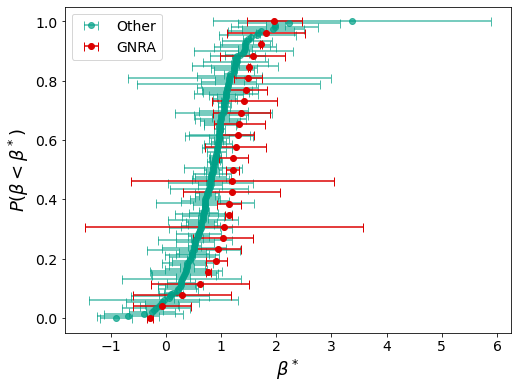

In [33]:
plt.figure(figsize = (8,6))

plt.errorbar(x = other_beta[idx_other],
             y = np.array(range(len(other_beta)))/(len(other_beta)-1), 
             xerr = other_err[idx_other],
             fmt = 'o', 
             capsize = 4.5,
             color = '#00A087FF',
             label = "Other",
             alpha = .7,
             barsabove = False)

plt.errorbar(x = gnra_beta[idx_gnra], 
             y = np.array(range(len(gnra_beta)))/(len(gnra_beta)-1), 
             xerr = other_err[idx_gnra], 
             fmt = 'o', 
             capsize = 4.5,
             color = "#DC0000FF",
             label = "GNRA",
             barsabove = False)


plt.ylabel(r"$P(\beta<\beta^*)$", size = 18)
plt.xlabel(r"$\beta^*$", size = 18)

plt.xticks(size = 14)
plt.yticks(size = 14)

plt.legend(fontsize = 14)
plt.savefig("/Users/nicola.calonaci/Documents/GitHub/paper-shapemd/Figures/beta_exp_scatter.png", dpi = 300)

### Distribution and statistical tests for $\beta$

In [6]:
from scipy import stats

stats.ttest_ind(gnra_beta,other_beta)

Ttest_indResult(statistic=2.821675269223014, pvalue=0.005320475420712254)

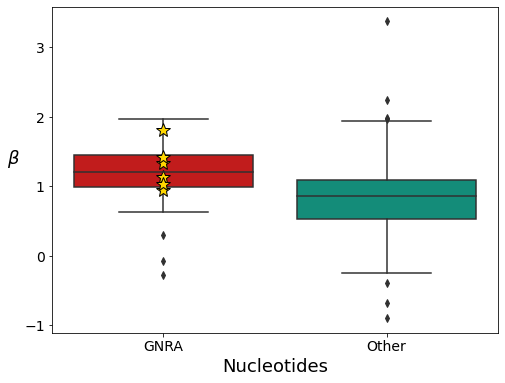

In [85]:
# Beta

plot_gnra_beta = np.nan*np.ones(other_beta.shape)
plot_gnra_beta[0:len(gnra_beta)] = gnra_beta

df_beta = pd.DataFrame(data = {"GNRA" : plot_gnra_beta, "Other" : other_beta})

pal = {"GNRA": "#DC0000FF", "Other" : '#00A087FF'} 

plt.figure(figsize = (8,6))

ax = sns.boxplot(data = df_beta, palette = pal)

x = np.repeat("GNRA", len(slope_g1))
y = np.ones(len(slope_g1))+slope_g1
plt.plot(x, y, "*", markersize = 14, color = "k",  markerfacecolor='gold')

ax.set_ylabel(r"$\beta$", rotation=0, size = 18, ha = "right")


plt.xlabel("Nucleotides", size = 18)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.xlim(-0.5,1.5)

plt.savefig("/Users/nicola.calonaci/Documents/GitHub/paper-shapemd/Figures/beta_exp_boxplot.png", dpi = 300)

### Distribution and statistical test for $\alpha$

In [8]:
from scipy import stats

stats.ttest_ind(gnra_alpha,other_alpha)

Ttest_indResult(statistic=4.053569252718743, pvalue=7.529443859393035e-05)

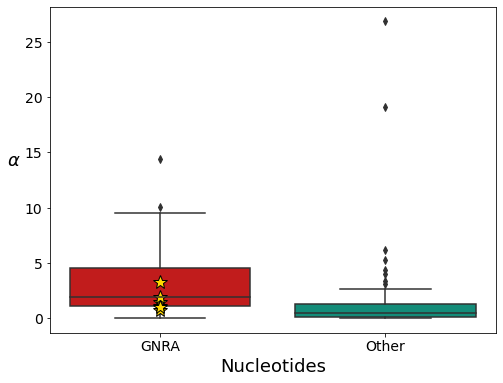

In [84]:
import seaborn as sns
import pandas as pd

# Alpha

plot_gnra_alpha = np.nan*np.ones(other_alpha.shape)
plot_gnra_alpha[0:len(gnra_alpha)] = gnra_alpha

# Plots

df_alpha = pd.DataFrame(data = {"GNRA" : plot_gnra_alpha, "Other" : other_alpha})

pal = {"GNRA": "#DC0000FF", "Other" : '#00A087FF'} 

plt.figure(figsize = (8,6))

ax = sns.boxplot(data = df_alpha, palette = pal)

x = np.repeat("GNRA", len(inter_g1))
y = np.ones(len(inter_g1))+inter_g1
plt.plot(x, y, "*", markersize = 14, color = "k",  markerfacecolor='gold')


ax.set_ylabel(r"$\alpha$", rotation= 0, size = 18, ha = "right")

plt.xlabel("Nucleotides", size = 18)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.savefig("/Users/nicola.calonaci/Documents/GitHub/paper-shapemd/Figures/alpha_exp_boxplot.png", dpi = 300)